# Юсипов Артур ИУ5-24М

#### Короткое описание датасета
> Прокат велосипедов в Лондоне.

Данные в датасете имеют информацию о погодных условиях, дате/времени и количестве велосипедов взятых на прокат в Лондоне за несколько лет

#### Описание анализируемых данных
Год — показывает год, когда велосипед взят в аренду.

Месяц — показывает месяц, когда велосипед взят в аренду.

День — показывает день, когда велосипед взят в аренду.

Время — показывает время в часах, когда велосипед взят в аренду.

Количество велосипедов — отражает количество велосипедов, которые были взяты напрокат.

Температура воздуха  — отражает температуру воздуха в градусах Цельсия.

Ощущаемая температура — отражает температуру воздуха, ощущаемую человеком в градусах Цельсия.

Влажность воздуха — показывает текущую влажность воздуха, выраженную в процентах.

Скорость ветра — показывает скорость ветра в километрах в час.

Код погоды — 1 - Ясно; 2 - Кучевые облака; 3 – Перистые облака 4 – Облачно; 7 - Дождь / Легкий дождь; 10 - Дождь с грозой; 26 – Снегопад; 94 - Замораживание тумана

Праздничный ли день — отражается в датасете в качестве 0/1.

Выходной ли день — отражается в датасете в качестве 0/1.

Сезон - Spring. Summer. Fall. Winter


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import sklearn
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv("london_merged.csv")
%matplotlib inline

In [3]:
# data.loc[data['season']==0, 'season'] = 'spring'
# data.loc[data['season']==1, 'season'] = 'summer'
# data.loc[data['season']==2, 'season'] = 'fall'
# data.loc[data['season']==3, 'season'] = 'winter'

data['hour'] = pd.DataFrame(data['timestamp'].apply(lambda x: pd.to_datetime(x).hour))
data['month'] = pd.DataFrame(data['timestamp'].apply(lambda x: pd.to_datetime(x).month))

In [4]:
del data['season']
del data['t2']
del data['timestamp']

In [5]:
data

,cnt,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,hour,month
0,182,3.0,93.0,6.0,3.0,0.0,1.0,0,1
1,138,3.0,93.0,5.0,1.0,0.0,1.0,1,1
2,134,2.5,96.5,0.0,1.0,0.0,1.0,2,1
3,72,2.0,100.0,0.0,1.0,0.0,1.0,3,1
4,47,2.0,93.0,6.5,1.0,0.0,1.0,4,1
...,...,...,...,...,...,...,...,...,...
17409,1042,5.0,81.0,19.0,3.0,0.0,0.0,19,1
17410,541,5.0,81.0,21.0,4.0,0.0,0.0,20,1
17411,337,5.5,78.5,24.0,4.0,0.0,0.0,21,1
17412,224,5.5,76.0,23.0,4.0,0.0,0.0,22,1


In [6]:
data_features = list(zip(
# признаки
[i for i in data.columns],
zip(
    # типы колонок
    [str(i) for i in data.dtypes],
    # проверим есть ли пропущенные значения
    [i for i in data.isnull().sum()]
)))
# Признаки с типом данных и количеством пропусков
data_features

[('cnt', ('int64', 0)),
 ('t1', ('float64', 0)),
 ('hum', ('float64', 0)),
 ('wind_speed', ('float64', 0)),
 ('weather_code', ('float64', 0)),
 ('is_holiday', ('float64', 0)),
 ('is_weekend', ('float64', 0)),
 ('hour', ('int64', 0)),
 ('month', ('int64', 0))]

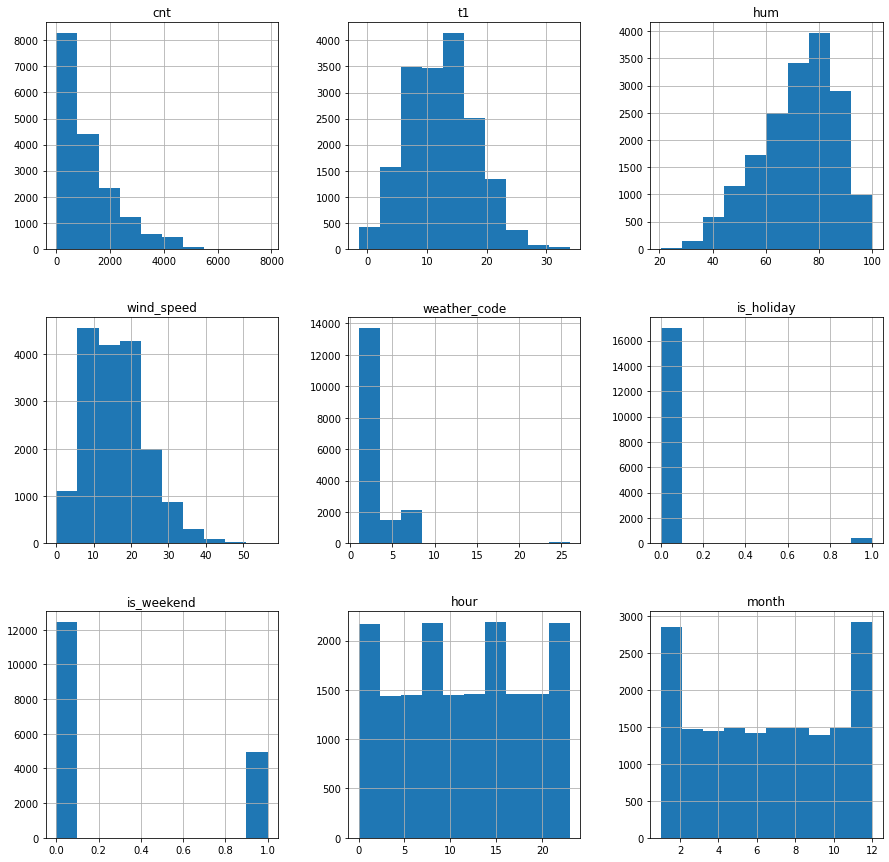

In [7]:
data.hist(figsize=(15,15));

# Нормализация числовых признаков

In [8]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,6))
    # гистограмма
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

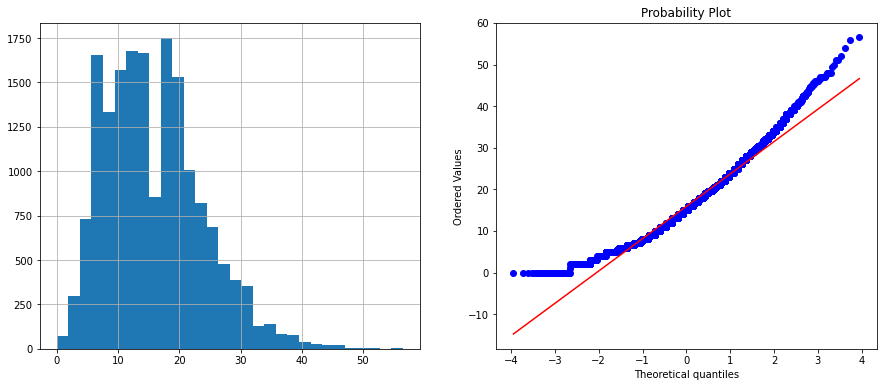

In [9]:
diagnostic_plots(data, 'wind_speed')

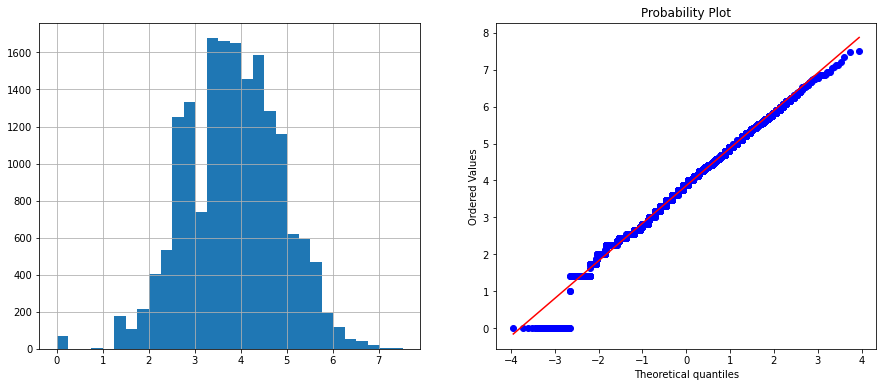

In [10]:
data['wind_speed_sqr'] = data['wind_speed']**(1/2) 
diagnostic_plots(data, 'wind_speed_sqr')

# Масштабирование 


In [11]:
del data['wind_speed']

data_scale = data.copy()
del data_scale['cnt']
del data_scale['is_holiday']
del data_scale['is_weekend']
del data_scale['weather_code']
data_scale.describe()

,t1,hum,hour,month,wind_speed_sqr
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,12.468091,72.324954,11.513265,6.514643,3.856172
std,5.571818,14.313186,6.915893,3.452509,1.021303
min,-1.500000,20.500000,0.000000,1.000000,0.000000
25%,8.000000,63.000000,6.000000,4.000000,3.162278
50%,12.500000,74.500000,12.000000,7.000000,3.872983
75%,16.000000,83.000000,18.000000,10.000000,4.527693
max,34.000000,100.000000,23.000000,12.000000,7.516648


In [12]:
# Функция для восстановления датафрейма
# на основе масштабированных данных
def arr_to_df(arr_scaled):
#     columns = ['t1', 'hum', 'weather_code', 'hour', 'wind_speed_sqr', 'month']
    res = pd.DataFrame(arr_scaled, columns=data_scale.columns)
    return res
# Масштабирование данных на основе Z-оценки
# x′=(x−μ(x))/σ(x)
# Обучаем StandardScaler на всей выборке и масштабируем
cs11 = StandardScaler()
data_cs11_scaled_temp = cs11.fit_transform(data_scale)
# формируем DataFrame на основе массива
data_cs11_scaled =  arr_to_df(data_cs11_scaled_temp)
data_cs11_scaled

,t1,hum,hour,month,wind_speed_sqr
0,-1.699331,1.444517,-1.664802,-1.597332,-1.377380
1,-1.699331,1.444517,-1.520204,-1.597332,-1.586356
2,-1.789071,1.689054,-1.375605,-1.597332,-3.775846
3,-1.878811,1.933590,-1.231007,-1.597332,-3.775846
4,-1.878811,1.444517,-1.086408,-1.597332,-1.279444
...,...,...,...,...,...
17409,-1.340371,0.606105,1.082572,-1.597332,0.492255
17410,-1.340371,0.606105,1.227170,-1.597332,0.711272
17411,-1.250632,0.431436,1.371769,-1.597332,1.021085
17412,-1.250632,0.256767,1.516368,-1.597332,0.920086


In [13]:
del data['t1'] 
del data['hum'] 
del data['hour'] 
del data['month'] 
del data['wind_speed_sqr'] 
data

,cnt,weather_code,is_holiday,is_weekend
0,182,3.0,0.0,1.0
1,138,1.0,0.0,1.0
2,134,1.0,0.0,1.0
3,72,1.0,0.0,1.0
4,47,1.0,0.0,1.0
...,...,...,...,...
17409,1042,3.0,0.0,0.0
17410,541,4.0,0.0,0.0
17411,337,4.0,0.0,0.0
17412,224,4.0,0.0,0.0


In [14]:
processed_data = pd.merge(data, data_cs11_scaled, left_index=True, right_index=True)
processed_data

,cnt,weather_code,is_holiday,is_weekend,t1,hum,hour,month,wind_speed_sqr
0,182,3.0,0.0,1.0,-1.699331,1.444517,-1.664802,-1.597332,-1.377380
1,138,1.0,0.0,1.0,-1.699331,1.444517,-1.520204,-1.597332,-1.586356
2,134,1.0,0.0,1.0,-1.789071,1.689054,-1.375605,-1.597332,-3.775846
3,72,1.0,0.0,1.0,-1.878811,1.933590,-1.231007,-1.597332,-3.775846
4,47,1.0,0.0,1.0,-1.878811,1.444517,-1.086408,-1.597332,-1.279444
...,...,...,...,...,...,...,...,...,...
17409,1042,3.0,0.0,0.0,-1.340371,0.606105,1.082572,-1.597332,0.492255
17410,541,4.0,0.0,0.0,-1.340371,0.606105,1.227170,-1.597332,0.711272
17411,337,4.0,0.0,0.0,-1.250632,0.431436,1.371769,-1.597332,1.021085
17412,224,4.0,0.0,0.0,-1.250632,0.256767,1.516368,-1.597332,0.920086


In [15]:
processed_data

,cnt,weather_code,is_holiday,is_weekend,t1,hum,hour,month,wind_speed_sqr
0,182,3.0,0.0,1.0,-1.699331,1.444517,-1.664802,-1.597332,-1.377380
1,138,1.0,0.0,1.0,-1.699331,1.444517,-1.520204,-1.597332,-1.586356
2,134,1.0,0.0,1.0,-1.789071,1.689054,-1.375605,-1.597332,-3.775846
3,72,1.0,0.0,1.0,-1.878811,1.933590,-1.231007,-1.597332,-3.775846
4,47,1.0,0.0,1.0,-1.878811,1.444517,-1.086408,-1.597332,-1.279444
...,...,...,...,...,...,...,...,...,...
17409,1042,3.0,0.0,0.0,-1.340371,0.606105,1.082572,-1.597332,0.492255
17410,541,4.0,0.0,0.0,-1.340371,0.606105,1.227170,-1.597332,0.711272
17411,337,4.0,0.0,0.0,-1.250632,0.431436,1.371769,-1.597332,1.021085
17412,224,4.0,0.0,0.0,-1.250632,0.256767,1.516368,-1.597332,0.920086


In [16]:
from sklearn.model_selection import train_test_split

def arr_to_df(arr_scaled):
    res = pd.DataFrame(arr_scaled, columns=x.columns)
    return res


x = processed_data.copy()
del x['cnt']

x

,weather_code,is_holiday,is_weekend,t1,hum,hour,month,wind_speed_sqr
0,3.0,0.0,1.0,-1.699331,1.444517,-1.664802,-1.597332,-1.377380
1,1.0,0.0,1.0,-1.699331,1.444517,-1.520204,-1.597332,-1.586356
2,1.0,0.0,1.0,-1.789071,1.689054,-1.375605,-1.597332,-3.775846
3,1.0,0.0,1.0,-1.878811,1.933590,-1.231007,-1.597332,-3.775846
4,1.0,0.0,1.0,-1.878811,1.444517,-1.086408,-1.597332,-1.279444
...,...,...,...,...,...,...,...,...
17409,3.0,0.0,0.0,-1.340371,0.606105,1.082572,-1.597332,0.492255
17410,4.0,0.0,0.0,-1.340371,0.606105,1.227170,-1.597332,0.711272
17411,4.0,0.0,0.0,-1.250632,0.431436,1.371769,-1.597332,1.021085
17412,4.0,0.0,0.0,-1.250632,0.256767,1.516368,-1.597332,0.920086


In [17]:
# Разделим выборку на обучающую и тестовую
# X_train, X_test, y_train, y_test = train_test_split(x, processed_data['cnt'],
#                                                     test_size=0.2,
#                                                     random_state=1)
# # Преобразуем массивы в DataFrame
# X_train_df = arr_to_df(X_train)
# X_test_df = arr_to_df(X_test)

# X_train_df.shape, X_test_df.shape, y_train.shape, y_test.shape

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error


# target_logistic_regression = logistic_regression.predict(X_test)

In [19]:
# X = data.drop(columns = ['timestamp','t2',
#                         'is_holiday','is_weekend',
#                         'season','year','month','day','cnt'])

y = data['cnt']
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.25)

In [20]:
lr = LinearRegression(fit_intercept = True, normalize = True)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [21]:
# round(y_pred.apply(lambda x:))
y_pred=list(map((lambda x: round(x)),y_pred))

In [22]:
y_pred

[1415,
 1263,
 738,
 694,
 1363,
 607,
 892,
 563,
 576,
 451,
 1559,
 531,
 2875,
 1916,
 2265,
 1324,
 1859,
 845,
 1975,
 1996,
 1082,
 261,
 1511,
 2181,
 237,
 999,
 1223,
 973,
 1023,
 1142,
 920,
 1122,
 451,
 1221,
 1071,
 890,
 2277,
 1742,
 863,
 1211,
 631,
 231,
 1373,
 1252,
 1170,
 1924,
 608,
 2302,
 684,
 734,
 1461,
 1315,
 838,
 1013,
 1246,
 530,
 1263,
 824,
 357,
 1970,
 278,
 659,
 2207,
 276,
 988,
 1289,
 2340,
 1421,
 1595,
 797,
 1268,
 621,
 525,
 1214,
 1221,
 533,
 543,
 1817,
 2341,
 2131,
 1311,
 840,
 1691,
 1199,
 2033,
 1504,
 1154,
 877,
 1426,
 262,
 938,
 873,
 1343,
 1286,
 993,
 1049,
 783,
 1039,
 869,
 179,
 2351,
 2345,
 1018,
 1040,
 2228,
 1426,
 1661,
 410,
 2264,
 431,
 1170,
 961,
 2395,
 325,
 1913,
 1014,
 547,
 828,
 2138,
 1938,
 733,
 429,
 783,
 -30,
 1318,
 213,
 1662,
 788,
 1997,
 438,
 595,
 2435,
 1062,
 1624,
 1296,
 587,
 987,
 1425,
 208,
 2567,
 981,
 1800,
 886,
 488,
 684,
 1609,
 838,
 1022,
 316,
 1166,
 2212,
 1567,
 58

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from sklearn.metrics import median_absolute_error, r2_score

In [24]:
print("Средняя абсолютная ошибка: {:.3f}".format(mean_absolute_error(y_test, y_pred)))
print("Средняя квадратичная ошибка: {:.3f}".format(mean_squared_error(y_test, y_pred, squared = False)))
print('Медианное абсолютное отклонение: {:.3f}'.format(median_absolute_error(y_test, y_pred)))
print('Коэффициент детерминации: {:.3f}'.format(r2_score(y_test, y_pred)))

Средняя абсолютная ошибка: 667.403
Средняя квадратичная ошибка: 922.846
Медианное абсолютное отклонение: 503.000
Коэффициент детерминации: 0.304


In [25]:
data = pd.read_csv("london_merged.csv")
data

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


In [26]:
data['hour'] = pd.DataFrame(data['timestamp'].apply(lambda x: pd.to_datetime(x).hour))
data['month'] = pd.DataFrame(data['timestamp'].apply(lambda x: pd.to_datetime(x).month))

del data['season']
del data['t2']
del data['timestamp']


In [27]:
data

,cnt,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,hour,month
0,182,3.0,93.0,6.0,3.0,0.0,1.0,0,1
1,138,3.0,93.0,5.0,1.0,0.0,1.0,1,1
2,134,2.5,96.5,0.0,1.0,0.0,1.0,2,1
3,72,2.0,100.0,0.0,1.0,0.0,1.0,3,1
4,47,2.0,93.0,6.5,1.0,0.0,1.0,4,1
...,...,...,...,...,...,...,...,...,...
17409,1042,5.0,81.0,19.0,3.0,0.0,0.0,19,1
17410,541,5.0,81.0,21.0,4.0,0.0,0.0,20,1
17411,337,5.5,78.5,24.0,4.0,0.0,0.0,21,1
17412,224,5.5,76.0,23.0,4.0,0.0,0.0,22,1


In [28]:
X = data.drop(columns = ['cnt'])

y = data['cnt']
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.25)

In [29]:
lr = LinearRegression(fit_intercept = True, normalize = True)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [30]:
y_pred=list(map((lambda x: round(x)),y_pred))
# y_pred

In [31]:
print("Средняя абсолютная ошибка: {:.3f}".format(mean_absolute_error(y_test, y_pred)))
print("Средняя квадратичная ошибка: {:.3f}".format(mean_squared_error(y_test, y_pred, squared = False)))
print('Медианное абсолютное отклонение: {:.3f}'.format(median_absolute_error(y_test, y_pred)))
print('Коэффициент детерминации: {:.3f}'.format(r2_score(y_test, y_pred)))

Средняя абсолютная ошибка: 660.935
Средняя квадратичная ошибка: 907.941
Медианное абсолютное отклонение: 516.500
Коэффициент детерминации: 0.309


### AutoML

In [33]:
# !pip3 install --user mljar-supervised
!pip3 install delayed
from supervised.automl import AutoML

In [44]:
automl = AutoML()

In [45]:
automl.fit(data[data.columns[1:]], data['cnt'])

AutoML directory: AutoML_3
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 1077.646165 trained in 0.17 seconds
2_DecisionTree rmse 763.445963 trained in 8.6 seconds
3_Linear rmse 999.034734 trained in 2.19 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 231.781599 trained in 10.96 seconds
5_Default_NeuralNetwork rmse 284.330774 trained in 1.91 seconds
6_Default_RandomForest rmse 736.721647 trained in 5.54 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 231.02035 trained in 0.15 seconds
AutoML fit time: 32.84 seconds


AutoML()